# **Case Study - Happy Deliveries (Ireland's Leading Food Delivery Service)**

## **Data Cleaning**

### **Cleaning Process**

#### **1. Orders Dataset**
- **Order Cancellations:** Removed orders with a status of "CANCELLED" since these transactions did not contribute to sales.
- **Handling Missing Values:** Missing values in `discount_code` and `discount_pc` were filled with "No Discount" and `0`, respectively, to indicate orders without discounts.
- **Date Formatting:** Converted `order_timestamp` and `delivered_timestamp` columns into `datetime` format for time-based analysis.

#### **2. Customers Dataset**
- **Outliers:** Removed customer records with unrealistic ages (e.g., ages above 100), which were likely due to data entry errors.

### **Managing Incomplete Data**
- Missing values in the `delivered_timestamp` column were flagged for further review. These may indicate potential delivery delays or operational issues.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.helpers import identify_missing_data
os.getcwd()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data into DataFrames
orders_data = pd.read_csv("../data/hd_orders.csv")

customers_data = pd.read_excel("../data/hd_customers.xlsx")

In [3]:
# Preview the first few rows orders datasets
orders_data.head()

,order_id,order_timestamp,delivered_timestamp,driver_id,restaurant_id,cust_id,delivery_region,discount_applied,discount_code,order_total,discount_pc,status
0,100001,26/11/2021 18:22,26/11/2021 18:49,273,105,1016,Dublin,True,BLACKFRIDAY21,69.46,20.0,COMPLETED
1,100002,11/07/2021 21:23,11/07/2021 21:53,43,219,1017,Cork,False,NaN,69.40,NaN,COMPLETED
2,100003,27/04/2021 17:28,27/04/2021 17:55,299,48,1019,Dublin,False,NaN,47.16,NaN,COMPLETED
3,100004,22/02/2021 18:08,22/02/2021 18:35,320,233,1020,Dublin,False,NaN,47.15,NaN,COMPLETED
4,100005,21/06/2021 18:14,21/06/2021 18:44,41,207,1024,Dublin,False,NaN,47.00,NaN,COMPLETED


In [5]:
# Get a concise summary of the orders_data DataFrame
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             998 non-null    int64  
 1   order_timestamp      998 non-null    object 
 2   delivered_timestamp  991 non-null    object 
 3   driver_id            998 non-null    int64  
 4   restaurant_id        998 non-null    int64  
 5   cust_id              998 non-null    int64  
 6   delivery_region      998 non-null    object 
 7   discount_applied     998 non-null    bool   
 8   discount_code        92 non-null     object 
 9   order_total          998 non-null    float64
 10  discount_pc          92 non-null     float64
 11  status               998 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 86.9+ KB


##### <u>1. Missing Values:</U>
delivered_timestamp: There are 7 missing values. This could indicate orders that were not delivered or incomplete records.
discount_code and discount_pc: These columns have many missing values (only 92 non-null entries), meaning most orders did not have a discount applied.

##### <u>2. Data Types:</U>
order_timestamp and delivered_timestamp: These are object types, which means they are stored as strings. For accurate analysis, these should be converted to datetime format to allow time-based operations.

##### <u>3. Potential Issues to Investigate:</U>
Missing Discounts: It seems most orders did not use a discount, but you need to ensure that missing values in discount_code and discount_pc are filled with appropriate defaults (e.g., "No Discount" for discount_code and 0 for discount_pc).
Missing Delivery Timestamps: For the missing delivered_timestamp, you might need to investigate whether these orders were incomplete or cancelled (or if any other information explains why they weren't delivered).

In [6]:
orders_data.shape

(998, 12)

In [7]:
# Convert 'order_timestamp' and 'delivered_timestamp' to datetime format
orders_data['order_timestamp'] = pd.to_datetime(orders_data['order_timestamp'], format="%d/%m/%Y %H:%M")
orders_data['delivered_timestamp'] = pd.to_datetime(orders_data['delivered_timestamp'], format="%d/%m/%Y %H:%M")

# Check if the conversion was successful by displaying the data types of the columns
orders_data[['order_timestamp', 'delivered_timestamp']].dtypes


order_timestamp        datetime64[ns]
delivered_timestamp    datetime64[ns]
dtype: object

#### 1: Check for Missing Values in the Entire DataFrame

In [8]:
# Check for missing values in the entire dataset
missing_values = orders_data.isnull().sum()

# Display the count of missing values per column
missing_values


order_id                 0
order_timestamp          0
delivered_timestamp      7
driver_id                0
restaurant_id            0
cust_id                  0
delivery_region          0
discount_applied         0
discount_code          906
order_total              0
discount_pc            906
status                   0
dtype: int64

##### <u> Missing Data Overview:</U>
* delivered_timestamp: 7 missing values.

* These could represent orders that were not delivered, incomplete data, or data entry errors.
discount_code and discount_pc: 906 missing values.

* This suggests that most orders did not have any discount applied, which is normal. However, we can fill these missing values with defaults (e.g., "No Discount" and 0 for discount_pc).

In [9]:
identify_missing_data(orders_data)

,variable,percent_missing,data_type
0,discount_code,90.78,object
1,discount_pc,90.78,float64
2,delivered_timestamp,0.70,datetime64[ns]


* discount_code (90.78% missing):

Data Type: object (likely string)
Action: Most orders do not use discount codes, so it's reasonable to fill these missing values with "No Discount" or a similar placeholder.

* discount_pc (90.78% missing):

Data Type: float64
Action: Since the missing values likely represent orders without discounts, you can fill them with 0, indicating no discount.

* delivered_timestamp (0.70% missing):

Data Type: datetime64[ns]
Action: As seen earlier, these missing timestamps are for cancelled orders, which should be removed from the dataset.

In [13]:
# Find rows where order_timestamp is missing
missing_order_rows = orders_data[orders_data['order_timestamp'].isnull()]

# Find rows where delivered_timestamp is missing
missing_delivery_rows = orders_data[orders_data['delivered_timestamp'].isnull()]

# Display the rows with missing timestamps
missing_order_rows, missing_delivery_rows

(Empty DataFrame
 Columns: [order_id, order_timestamp, delivered_timestamp, driver_id, restaurant_id, cust_id, delivery_region, discount_applied, discount_code, order_total, discount_pc, status]
 Index: [],
      order_id     order_timestamp delivered_timestamp  driver_id  \
 30     100031 2021-07-22 23:42:00                 NaT         66   
 64     100065 2021-03-02 20:12:00                 NaT        204   
 116    100117 2021-10-17 17:34:00                 NaT        232   
 175    100176 2021-10-08 18:11:00                 NaT        216   
 206    100207 2021-11-10 21:35:00                 NaT        353   
 241    100242 2021-01-01 20:16:00                 NaT        288   
 954    100955 2022-12-15 17:03:00                 NaT        368   
 
      restaurant_id  cust_id delivery_region  discount_applied discount_code  \
 30              63     1081            Cork             False           NaN   
 64             241     1153          Dublin             False           NaN   

From your output, it looks like all rows with missing delivered_timestamp have a "CANCELLED" status. This makes sense because cancelled orders would not have a valid delivery timestamp. Since these orders are cancelled, they should be removed from the dataset as they do not represent completed transactions.

In [11]:
# Remove rows where the status is 'CANCELLED'
orders_data_cleaned = orders_data[orders_data['status'] != 'CANCELLED']

# Verify that cancelled orders are removed
orders_data_cleaned.isnull().sum()

order_id                 0
order_timestamp          0
delivered_timestamp      0
driver_id                0
restaurant_id            0
cust_id                  0
delivery_region          0
discount_applied         0
discount_code          899
order_total              0
discount_pc            899
status                   0
dtype: int64

In [14]:
# Count the occurrences of each discount code in the orders dataset
discount_code_counts = orders_data['discount_code'].value_counts()

# Display the result
discount_code_counts

discount_code
BLACKFRIDAY22    46
BLACKFRIDAY21    25
HAPPYBIRTHDAY    21
Name: count, dtype: int64

In [15]:
# Count the occurrences of each discount percentage in the orders dataset
discount_pc_counts = orders_data['discount_pc'].value_counts()

# Display the result
discount_pc_counts

discount_pc
20.0    71
10.0    21
Name: count, dtype: int64

In [16]:
# Fill missing values in discount_code with 'No Discount'
orders_data_cleaned['discount_code'].fillna('No Discount', inplace=True)

# Fill missing values in discount_pc with 0 (indicating no discount)
orders_data_cleaned['discount_pc'].fillna(0, inplace=True)

# Verify that the missing values are filled
orders_data_cleaned[['discount_code', 'discount_pc']].isnull().sum()


discount_code    0
discount_pc      0
dtype: int64

In [18]:
orders_data_cleaned['discount_code'].value_counts()

discount_code
No Discount      899
BLACKFRIDAY22     46
BLACKFRIDAY21     25
HAPPYBIRTHDAY     21
Name: count, dtype: int64

In [17]:
orders_data_cleaned['discount_pc'].value_counts()

discount_pc
0.0     899
20.0     71
10.0     21
Name: count, dtype: int64

In [19]:
orders_data_cleaned.isnull().sum()

order_id               0
order_timestamp        0
delivered_timestamp    0
driver_id              0
restaurant_id          0
cust_id                0
delivery_region        0
discount_applied       0
discount_code          0
order_total            0
discount_pc            0
status                 0
dtype: int64

In [20]:
# Check if data has duplicated rows.
orders_data_cleaned.duplicated().sum()

0

In [21]:
orders_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991 entries, 0 to 997
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             991 non-null    int64         
 1   order_timestamp      991 non-null    datetime64[ns]
 2   delivered_timestamp  991 non-null    datetime64[ns]
 3   driver_id            991 non-null    int64         
 4   restaurant_id        991 non-null    int64         
 5   cust_id              991 non-null    int64         
 6   delivery_region      991 non-null    object        
 7   discount_applied     991 non-null    bool          
 8   discount_code        991 non-null    object        
 9   order_total          991 non-null    float64       
 10  discount_pc          991 non-null    float64       
 11  status               991 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 93.9+ KB


In [22]:
print("orginal data frame", orders_data.shape)
print("transformed data frame", orders_data_cleaned.shape)

orginal data frame (998, 12)
transformed data frame (991, 12)


In [23]:
# Saving the orders_data to the specified path "../data/hd_orders.csv"
#orders_data_cleaned.to_csv("../data/orders_cleaned.csv", index=False)

##### Data cleaning for the customers_data

In [24]:
# Preview the first few rows of customer datasets
customers_data.head()

,id,first_name,last_name,age,city,email
0,1001,Samuel,Zavala,139,Dublin,Zavala_Samuel46@xfinity.com
1,1002,Sara,Lee,33,Dublin,Sara.L@hotmail.com
2,1003,Michael,Davidson,23,Dublin,MichaelDavidson82@att.com
3,1004,Willie,Sims,29,Sligo,Willie_S@yahoo.com
4,1005,Carly,Armstrong,22,Mayo,CArmstrong@mail.com


In [18]:
# Get a concise summary of the customers_data DataFrame
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          406 non-null    int64 
 1   first_name  406 non-null    object
 2   last_name   406 non-null    object
 3   age         406 non-null    int64 
 4   city        406 non-null    object
 5   email       406 non-null    object
dtypes: int64(2), object(4)
memory usage: 19.2+ KB


In [19]:
# Check for missing values in the entire dataset
missing_values =customers_data.isnull().sum()

# Display the count of missing values per column
missing_values

id            0
first_name    0
last_name     0
age           0
city          0
email         0
dtype: int64

In [21]:
customers_data.duplicated().sum()

0

In [25]:
# Describe the numerical columns in the customers DataFrame
customers_summary = customers_data.describe()

# Display the summary
print(customers_summary)

                id         age
count   406.000000  406.000000
mean   1203.500000   29.354680
std     117.346353   14.347274
min    1001.000000    6.000000
25%    1102.250000   22.000000
50%    1203.500000   26.000000
75%    1304.750000   31.000000
max    1406.000000  160.000000


 I want to inspect the age column for outliers or input errors (e.g., ages like 160) and clean that up.

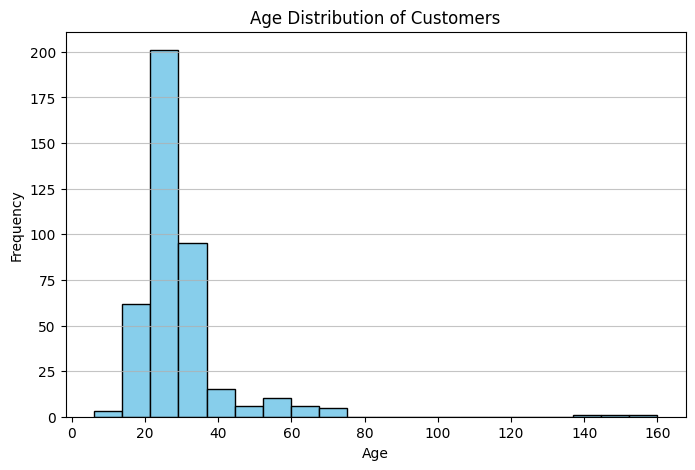

In [26]:
# Plotting the age distribution as a histogram
plt.figure(figsize=(8, 5))
plt.hist(customers_data['age'], bins=20, edgecolor='black', color='skyblue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

The age distribution shows a concentration of customers between the ages of 20 and 40, with some outliers above 100 years of age, particularly the one at 160 years old. This is most likely a data entry error and should be addressed as part of data cleaning.

In [28]:
customers_data['age'].value_counts()

age
22     41
23     35
21     30
24     26
26     26
28     26
30     23
31     21
25     19
33     19
27     15
32     14
29     13
20     13
34     13
19     11
18      8
37      5
35      3
58      3
43      2
36      2
55      2
41      2
45      2
38      2
6       2
42      2
59      2
68      2
67      2
49      2
60      1
62      1
40      1
46      1
75      1
61      1
70      1
139     1
44      1
57      1
53      1
47      1
54      1
8       1
150     1
66      1
71      1
160     1
Name: count, dtype: int64

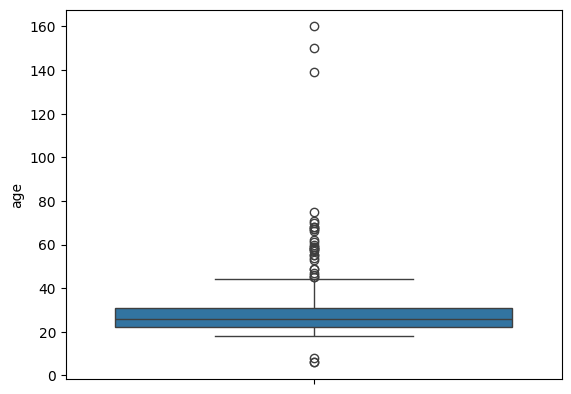

In [29]:
sns.boxplot(y="age", data=customers_data)
plt.show;

Main Age Distribution: The majority of customer ages are concentrated between approximately 20 and 40 years old, with a few data points extending beyond this range.

Outliers:
There are extreme outliers above the 100-year mark (e.g., 139, 150, 160) as well as some smaller outliers below the main range (around 6 and 8 years old).

These extreme ages are likely errors and should be handled.

In [31]:
# Filter for customers with age less than 18 or greater than 80
outliers = customers_data[(customers_data['age'] < 18) | (customers_data['age'] > 80)]

# Display the outliers
outliers

,id,first_name,last_name,age,city,email
0,1001,Samuel,Zavala,139,Dublin,Zavala_Samuel46@xfinity.com
30,1031,Jessica,Hendricks,150,Dublin,Jessica.H85@xfinity.com
59,1060,Amy,Farmer,8,Kerry,Farmer.Amy@verizon.com
70,1071,David,Gibson,160,Dublin,DavidGibson@xfinity.com
102,1103,Andrew,Craig,6,Dublin,Andrew.C74@yahoo.com
164,1165,Christopher,Ramsey,6,Waterford,Ramsey_Christopher@hotmail.com


In [33]:
# Calculate the 1st and 99th percentile values for the 'age' column
min_threshold, max_threshold = customers_data['age'].quantile([0.01, 0.99])

# Display the calculated thresholds
min_threshold, max_threshold

(18.0, 70.94999999999999)

In [35]:
valid_age = customers_data['age'].between(18, 80)
age_clean_df = customers_data.loc[valid_age, :]
age_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 405
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          400 non-null    int64 
 1   first_name  400 non-null    object
 2   last_name   400 non-null    object
 3   age         400 non-null    int64 
 4   city        400 non-null    object
 5   email       400 non-null    object
dtypes: int64(2), object(4)
memory usage: 21.9+ KB


In [36]:
age_clean_df.describe()

,id,age
count,400.000000,400.000000
mean,1205.475000,28.622500
std,116.924496,9.753863
min,1002.000000,18.000000
25%,1105.750000,22.000000
50%,1206.500000,26.000000
75%,1306.250000,31.000000
max,1406.000000,75.000000


In [37]:
print("orginal data frame", customers_data.shape)
print("transformed data frame", age_clean_df.shape)

orginal data frame (406, 6)
transformed data frame (400, 6)


In [39]:
# Saving the orders_data to the specified path "../data/hd_orders.csv"
# age_clean_df.to_csv("../data/customers_cleaned.csv", index=False)